<!-- richman tutorlal oroginal -->

In [ ]:

# import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd

import seaborn as sns
import talib

import pandas as pd
import sys
sys.path.append("../../../")
from common.constants import DATAFOLDER
from typing import MutableSequence, Optional, Dict
import os
import numpy as np
import omegaconf
import matplotlib.pyplot as plt
# from common.feature_aggregation.talib import agg_feature
# from common.feature_aggregation.features import highest, sma, realized_volatility, std, lowest
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import joblib
from common.evaluate.backtest import backtest

from sklearn.metrics import mean_squared_error
from common.evaluate.evaluate import evaluation_index

# from common.feature_aggregation.default import agg_feature_default
# from information_coefficient.preprocess.corr_cols import IC, corr_column, target_calucuration
# from information_coefficient.preprocess.make_data import feature_calcuration

import pickle

: 

In [19]:
# パラメータ
exchange_name: Optional[str] = 'gmo'
trading_type = 'margin'
pair_name = 'BTC_JPY'
time_bar = '15T'
fee_percent = 0.0 
execution_type = 'LIMIT'
features = sorted(['MIDPRICE5_tilt', 'close_MIDPRICE5_highest_15_ratio', 'BBANDS_ratio_1', 'BBANDS_ratio_2_tilt', 'BBANDS_ratio_2_acceleration', 'DEMA5_close_ratio', 'HT_TRENDLINE_acceleration', 'KAMA5_tilt', 'KAMA5_acceleration', 'close_KAMA5_highest_5_ratio', 'MMA_acceleration', 'TRIMA5_acceleration', 'ADX_tilt', 'ADX_acceleration', 'ADXR_tilt', 'ADXR_acceleration', 'aroonup', 'BOP', 'close_BOP_mean_5_ratio', 'CCI', 'close_CMD_highest_15_ratio', 'MOM', 'PLUS_DM', 'close_PLUS_DM_mean_15_ratio', 'PPO', 'RSI_close_ratio', 'RSI_tilt', 'RSI_acceleration', 'fastk_STOCHF_fastd_STOCHF_ratio', 'fastk_STOCHRSI', 'fastd_STOCHRSI', 'fastk_STOCHRSI_fastd_STOCHRSI_ratio', 'TRIX', 'close_WILLR_mean_15_ratio', 'NATR', 'close_TRANGE_highest_15_ratio', 'close_inphase_quadrature_ratio_highest_15_ratio', 'integer', 'WCLPRICE_close_ratio', 'CDLDOJI', 'CDLBELTHOLD', 'CDLSHORTLINE', 'CDLSPINNINGTOP', 'LINEARREG5_acceleration', 'LINEARREG_SLOPE5', 'VAR', 'close_VAR_highest_15_ratio', 'close_TSF5_highest_15_ratio', 'STDDEV', 'LINEARREG_ANGLE5', 'CORREL5', 'ATAN_tilt', 'ATAN_acceleration', 'CEIL_acceleration', 'close_CEIL_highest_5_ratio', 'MULT_tilt', 'MULT_acceleration', 'close_MULT_highest_5_ratio', 'DIV', 'DIV_tilt', 'close_MAX120_highest_15_ratio', 'MIN120_close_ratio', 'MIN120_tilt'])
# features = sorted(['close_highest5_ratio_tilt', 'close_highest15_ratio_tilt', 'close_highest45_ratio_shift_tilt', 'close_5daysAgoclose_ratio_tilt', 'close_10daysAgoclose_ratio_tilt', 'close_10daysAgoclose_ratio_acceleration', 'close_15daysAgoclose_ratio_tilt', 'close_20daysAgoclose_ratio_tilt', 'close_20daysAgoclose_ratio_acceleration', 'high_low_ratio_5sma', 'close_high_low_ratio_5sma_ratio_acceleration', 'high_low_ratio_15sma', 'close_high_low_ratio_15sma_highest_30_ratio', 'high_low_ratio_60sma', 'close_close_high_low_ratio_60sma_ratio_highest_5_ratio', 'high_low_ratio_120sma', 'close_Volume_15daysago_ratio_mean_30_ratio', 'sma_cci_acceleration', 'mean_deviation_acceleration', 'log_return1', 'close_log_return1_highest_15_ratio', 'close_log_return1_highest_30_ratio', 'log_return2', 'close_price_spread_mean_15_ratio', 'upper_close_ratio', 'upper_acceleration', 'lower_tilt', 'in_upper', 'in_upper_tilt', 'inner_candle_buy', 'inner_candle_buy_tilt', 'MIDPRICE5_tilt', 'upperband_close_ratio', 'upperband_tilt', 'lowerband_close_ratio', 'lowerband_tilt', 'lowerband_acceleration', 'BBANDS_ratio_1', 'KAMA5_tilt', 'KAMA5_acceleration', 'close_KAMA5_highest_5_ratio', 'TRIMA5_acceleration', 'close_WMA5_highest_30_ratio', 'ADX_tilt', 'BOP', 'close_BOP_mean_30_ratio', 'close_CMD_highest_15_ratio', 'PLUS_DM', 'close_PLUS_DM_mean_15_ratio', 'ROCR_30_tilt', 'ROCR_120_tilt', 'ROCR_120_acceleration', 'ROCR100_60_tilt', 'ROCR100_60_acceleration', 'RSI_tilt', 'fastk_STOCHF_fastd_STOCHF_ratio', 'fastk_STOCHRSI', 'fastd_STOCHRSI', 'fastk_STOCHRSI_fastd_STOCHRSI_ratio', 'ATR_close_ratio', 'NATR', 'NATR_tilt', 'close_inphase_highest_30_ratio', 'close_quadrature_highest_15_ratio', 'close_quadrature_highest_30_ratio', 'LINEARREG_SLOPE5', 'VAR', 'close_TSF5_highest_15_ratio', 'STDDEV', 'CORREL5', 'ATAN_tilt', 'DIV', 'close_MAX120_highest_30_ratio', 'MIN30_tilt', 'MIN60_close_ratio', 'MIN60_tilt', 'MIN120_tilt'])
print(len(features))

target_dict = {
    "target_feature": f"y_buy_5",
    "y_buy": f"y_buy",
    "y_sell": f"y_sell", 
    "buy_executed": f"buy_executed",
    "sell_executed": f"sell_executed",
    "buy_price": f"buy_price",
    "sell_price": f"sell_price",
}

63


In [20]:
def get_IC_scores_list(exchange_name: str, trading_type: str, pair_name: str, time_bar: str, target_feature: str):
    IC_scores_df = pd.read_csv(f"../../../information_coefficient/result/IC_feature/{exchange_name}_{trading_type}_{pair_name}_{time_bar}.csv")
    IC_scores_df = IC_scores_df.drop_duplicates(subset="Unnamed: 0")
    IC_scores_df = IC_scores_df.set_index("Unnamed: 0")
    IC_scores_df = IC_scores_df.abs()
    IC_scores_df = IC_scores_df.sort_values(target_feature, ascending=False)

    # lasso回帰の候補とする特長量の個数を指定
    num_feature = 1000
    IC_scores_list = IC_scores_df.index.values.tolist()[:num_feature]
    display(IC_scores_df[:num_feature])
    return IC_scores_list, IC_scores_df

IC_scores_list, IC_scores_df = get_IC_scores_list(exchange_name, trading_type, pair_name, time_bar, target_dict["target_feature"])

,y_buy_1,y_sell_1,y_buy_5,y_sell_5,y_buy_10,y_sell_10
Unnamed: 0,,,,,,
close_CMD_highest_15_ratio,0.001076,0.000641,0.068638,0.000588,0.023800,0.000626
upperband_close_ratio,0.034957,0.040443,0.058794,0.000930,0.018131,0.008565
DIV,0.027343,0.043037,0.057834,0.005787,0.029667,0.012163
close_aroonup_mean_15_ratio,0.060563,0.000144,0.057300,0.000022,0.000022,0.000057
price_spread,0.027064,0.041342,0.057211,0.006599,0.028207,0.012867
...,...,...,...,...,...,...
close_MAX120_highest_5_ratio,0.006384,0.023859,0.014203,0.006501,0.004358,0.001015
close_high_low_ratio_15sma_std_5_ratio,0.008294,0.015380,0.014132,0.010004,0.008631,0.002146
close_NATR_std_15_ratio,0.011655,0.019010,0.014118,0.014915,0.011744,0.005678


In [21]:
# ohlcvデータの読み込み
df= pd.read_parquet(
            os.path.join(DATAFOLDER.ohlc_data_folder, time_bar, f"{exchange_name}_{trading_type}_{pair_name}.parquet.gzip"),
            engine="pyarrow",
        )

df = df['2019/01/01 00:00:00':]
df = df.drop_duplicates()

df = df.fillna(method="ffill")
df = df[-2000000:]
display(df)

,open,high,low,close,volume
timestamp,,,,,
2019/01/01 00:00:00,406403.0,407049.0,405894.0,406000.0,1.51
2019/01/01 00:15:00,406160.0,407488.0,405800.0,406096.0,3.76
2019/01/01 00:30:00,406500.0,407200.0,406176.0,406500.0,2.70
2019/01/01 00:45:00,407490.0,407500.0,406778.0,406780.0,6.01
2019/01/01 01:00:00,406490.0,407080.0,406469.0,406469.0,7.25
...,...,...,...,...,...
2022/04/18 19:45:00,5140532.0,5169462.0,5132076.0,5163500.0,42.99
2022/04/18 20:00:00,5164677.0,5196709.0,5163766.0,5180410.0,54.23
2022/04/18 20:15:00,5181263.0,5186171.0,5161076.0,5168880.0,25.82


約定確率を可視化。時期によって約定確率が大きく変わると良くない。


/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32004 (\N{CJK UNIFIED IDEOGRAPH-7D04}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from curr

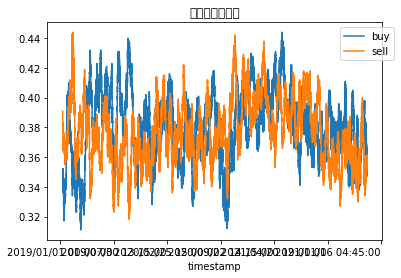

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12464 (\N{KATAKANA LETTER GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from current font.
  fig.canvas.prin

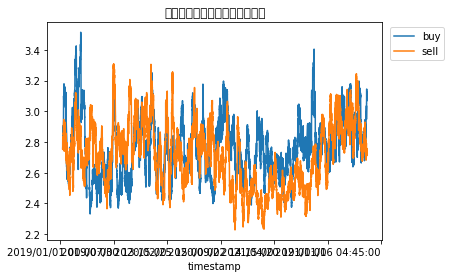

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


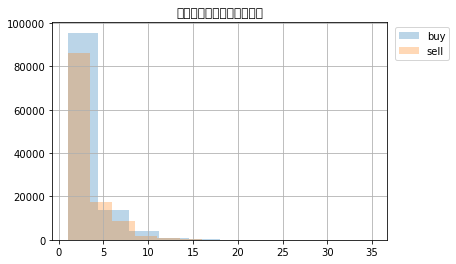

毎時刻、この執行方法でトレードした場合の累積リターン


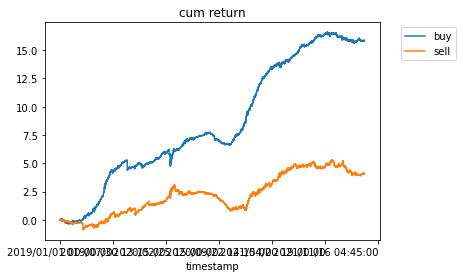

約定した時に、buy targetが正の確率は63.91% 平均利益は、0.3301% 平均損失は。-0.484% 平均損益は0.0363%
約定した時に、sell targetが正の確率は62.45% 平均利益は、0.3167% 平均損失は。-0.5019% 平均損益は0.0093%


,open,high,low,close,volume,fee,ATR,buy_price,sell_price,buy_fep,buy_fet,sell_fep,sell_fet,buy_executed,sell_executed,y_buy,y_sell,buy_cost,sell_cost
timestamp,,,,,,,,,,,,,,,,,,,
2019/01/01 00:00:00,406403.0,407049.0,405894.0,406000.0,1.51,0.0,NaN,405999.0,406001.0,405999.0,1.0,406001.0,1.0,1.0,1.0,0.000241,-0.001916,-0.000002,-0.000002
2019/01/01 00:15:00,406160.0,407488.0,405800.0,406096.0,3.76,0.0,NaN,406095.0,406097.0,406779.0,3.0,406097.0,1.0,0.0,1.0,0.000000,-0.001679,0.000000,-0.000002
2019/01/01 00:30:00,406500.0,407200.0,406176.0,406500.0,2.70,0.0,NaN,406499.0,406501.0,406779.0,2.0,406501.0,1.0,0.0,1.0,0.000000,-0.000684,0.000000,-0.000002
2019/01/01 00:45:00,407490.0,407500.0,406778.0,406780.0,6.01,0.0,NaN,406779.0,406781.0,406779.0,1.0,406781.0,1.0,1.0,1.0,-0.001913,0.000769,-0.000002,-0.000002
2019/01/01 01:00:00,406490.0,407080.0,406469.0,406469.0,7.25,0.0,NaN,406468.0,406470.0,406468.0,1.0,406001.0,2.0,1.0,0.0,-0.001149,0.000000,-0.000002,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022/04/18 19:45:00,5140532.0,5169462.0,5132076.0,5163500.0,42.99,0.0,31915.602722,5147542.0,5179458.0,5164406.0,2.0,5179458.0,1.0,0.0,1.0,0.000000,0.002906,0.000000,-0.003091
2022/04/18 20:00:00,5164677.0,5196709.0,5163766.0,5180410.0,54.23,0.0,32007.988242,5164406.0,5196414.0,5164406.0,1.0,NaN,NaN,1.0,0.0,NaN,0.000000,-0.003089,0.000000
2022/04/18 20:15:00,5181263.0,5186171.0,5161076.0,5168880.0,25.82,0.0,31514.203368,5153123.0,5184637.0,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [22]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time
df['fee'] = 0.0
open = df['open']
high = df['high']
low = df['low']
close = df['close']
volume = df['volume']

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1
# buy_price
i = 0.1

# sell price
# ATR の計算方法を変更
# df['buy_price'], df['sell_price'] = position_price_by_atr(df, pips, 1)
df['ATR'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# # 終値から両側にlimit_price_distだけ離れたところに、buy指値とsell指値を出します
df['buy_price'] = df['close'] - limit_price_dist
df['sell_price'] = df['close'] + limit_price_dist

df["buy_price"] = df["buy_price"].fillna(10000000)
df["sell_price"] = df["sell_price"].fillna(0)

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['low'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすればsellに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['high'].values, # sellのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['low'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['high'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['close'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['close'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='buy')
df['sell_executed'].rolling(1000).mean().plot(label='sell')
plt.title('約定確率の推移')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='buy')
df['sell_fet'].rolling(1000).mean().plot(label='sell')
plt.title('エグジットまでの平均時間推移')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='buy')
df['sell_fet'].hist(alpha=0.3, label='sell')
plt.title('エグジットまでの時間分布')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='buy')
df['y_sell'].cumsum().plot(label='sell')
plt.title('cum return')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# df.to_pickle('df_y.pkl')

win_percent_of_buy = 100 * (df['y_buy'] > 0).sum() / ((df['y_buy'] > 0).sum() + (df['y_buy'] < 0).sum())
win_percent_of_sell = 100 * (df['y_sell'] > 0).sum() /  ((df['y_sell'] > 0).sum() + (df['y_sell'] < 0).sum())
average_profit_buy = 100 * df[df['y_buy'] > 0]['y_buy'].mean()
average_profit_sell = 100 * df[df['y_sell'] > 0]['y_sell'].mean()
average_loss_buy = 100 * df[df['y_buy'] < 0]['y_buy'].mean()
average_loss_sell = 100 * df[df['y_sell'] < 0]['y_sell'].mean()

print(f'約定した時に、buy targetが正の確率は{round(win_percent_of_buy,2)}% 平均利益は、{round(average_profit_buy,4)}% 平均損失は。{round(average_loss_buy,4)}% 平均損益は{round(win_percent_of_buy/100*average_profit_buy + (1-win_percent_of_buy/100)*average_loss_buy,4)}%')
print(f'約定した時に、sell targetが正の確率は{round(win_percent_of_sell,2)}% 平均利益は、{round(average_profit_sell,4)}% 平均損失は。{round(average_loss_sell,4)}% 平均損益は{round(win_percent_of_sell/100*average_profit_sell + (1-win_percent_of_sell/100)*average_loss_sell,4)}%')

display(df)

In [23]:
def plot_scatter(target, feature, x, returns, normalize=False):
    """
    :param np.ndarray x: 指標
    :param np.ndarray returns: リターン
    :param bool normalize: x をスケーリングするかどうか
    """
    assert(len(x) == len(returns))
    # 正規化
    x = (x - x.mean()) / x.std() if normalize else x
    returns = (returns - returns.mean()) / returns.std() if normalize else returns
    
    # 散布図
    plt.plot(x, returns, 'x')
    # 回帰直線
    reg = np.polyfit(x, returns, 1)
    plt.plot(x, np.poly1d(reg)(x), color='c', linewidth=2)
    # 区間平均値
    plt.plot(*_steps(x, returns), drawstyle='steps-mid', color='r', linewidth=2)

    # 相関係数（情報係数）
    ic = np.corrcoef(x, returns)[0, 1]
    plt.title(f'{target},{feature}, IC={ic:.3f}, y={reg[0]:.3f}x{reg[1]:+.3f}')
    plt.grid()
    plt.show()
    plt.close()
    
    return ic

def _steps(x, y):
    int_x = np.round(x)
    ret_x = np.unique(int_x)
    ret_y = []
    for xa in ret_x:
        ret_y.append(np.average(y[int_x == xa]))
    return ret_x, np.array(ret_y)


In [24]:
# df_result = feature_calcuration(df, features, IC_scores_df, target_dict)
# before_len = len(df_result)
# # 相関関係のある特徴量を削除
# columns = corr_column(df_result, 0.8, target_dict["target_feature"], IC_scores_df)

# # target
# # df = target_calucuration(df,target_dict)
# df = pd.concat([df, df_result[columns]], axis=1)
# df.dropna(inplace=True)
# df = df.round(12)
# display(df)

# embargo = len(df_result) - before_len
# print(f'embargo:{embargo}')

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,MIDPRICE5_tilt,close_MIDPRICE5_highest_15_ratio,BBANDS_ratio_1,BBANDS_ratio_2_tilt,BBANDS_ratio_2_acceleration,DEMA5_close_ratio,HT_TRENDLINE_acceleration,KAMA5_tilt,KAMA5_acceleration,close_KAMA5_highest_5_ratio,...,CEIL_acceleration,close_CEIL_highest_5_ratio,MULT_tilt,MULT_acceleration,close_MULT_highest_5_ratio,DIV,DIV_tilt,close_MAX120_highest_15_ratio,MIN120_close_ratio,MIN120_tilt
timestamp,,,,,,,,,,,,,,,,,,,,,
2019/01/01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.002846,NaN,NaN,NaN,NaN
2019/01/01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.000847,NaN,NaN,1.004160,1.001310,NaN,NaN,NaN
2019/01/01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000758,NaN,1.000219,0.999373,NaN,1.002521,0.998368,NaN,NaN,NaN
2019/01/01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.999694,NaN,1.002220,1.002000,NaN,1.001775,0.999256,NaN,NaN,NaN
2019/01/01 01:00:00,NaN,NaN,1.001404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.998548,0.999235,0.998210,0.995999,2.452124e-06,1.001503,0.999729,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022/04/18 19:45:00,1.001283,1.014068,1.003519,0.999537,1.000249,1.000350,0.999885,1.000051,0.999444,1.006961,...,1.007367,1.000000,1.002613,1.007277,1.937435e-07,1.007285,1.003433,0.997560,1.051009,1.0
2022/04/18 20:00:00,1.001913,1.015447,1.005559,1.004088,1.004553,1.001159,0.999952,1.000440,1.000389,1.009814,...,0.998787,1.000000,1.011478,1.008842,1.930497e-07,1.006380,0.999101,1.000000,1.054451,1.0
2022/04/18 20:15:00,1.001975,1.011189,1.005204,0.999291,0.995223,0.998947,0.999927,1.000496,1.000056,1.007068,...,0.994517,0.997774,0.997452,0.986133,1.926201e-07,1.004862,0.998492,0.997774,1.052105,1.0


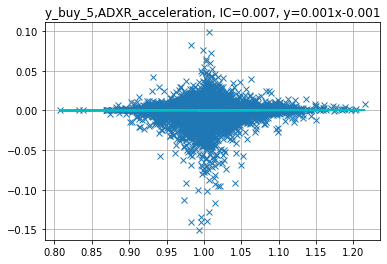

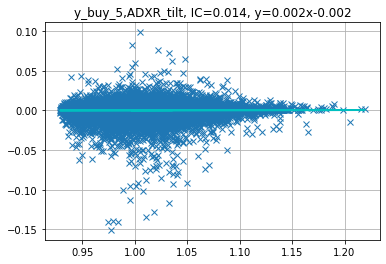

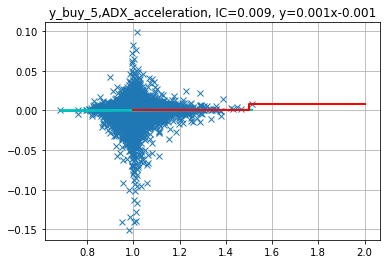

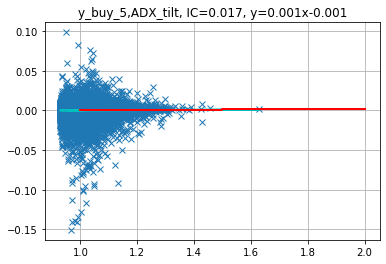

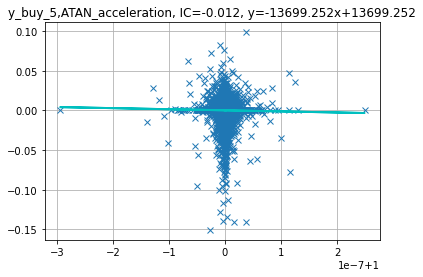

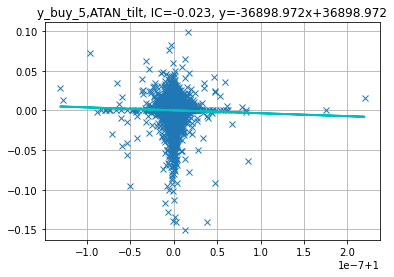

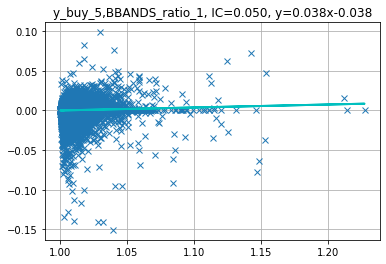

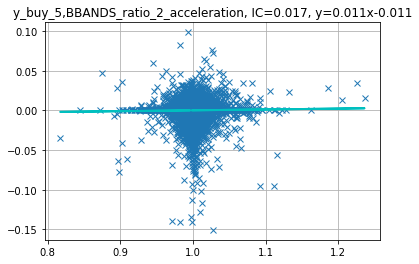

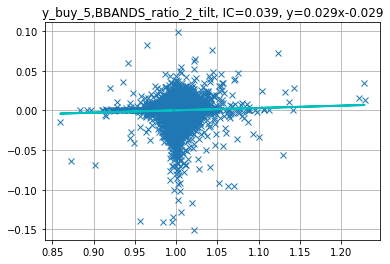

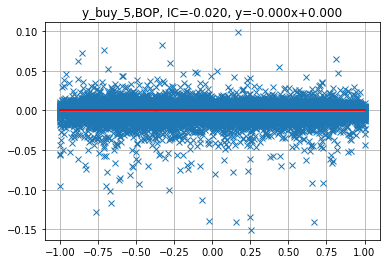

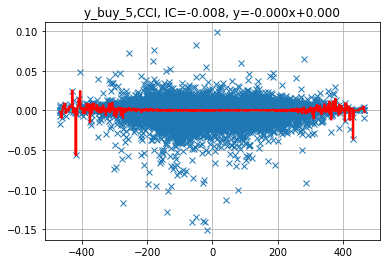

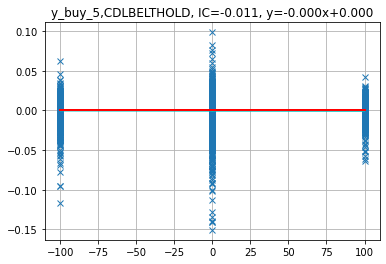

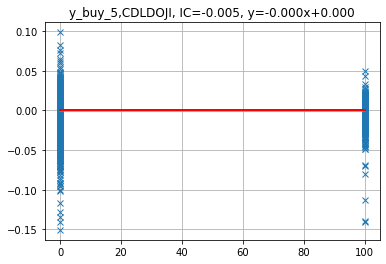

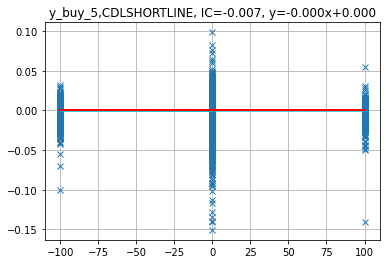

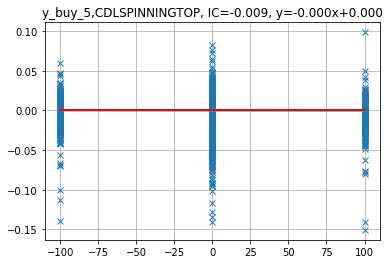

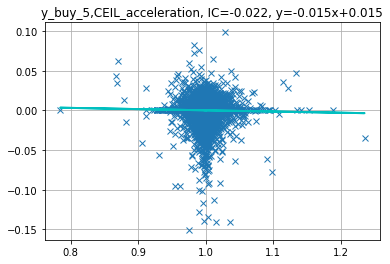

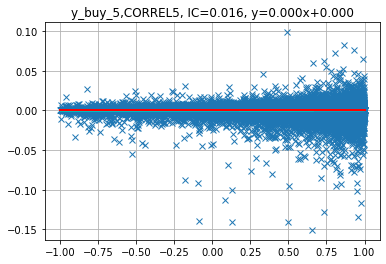

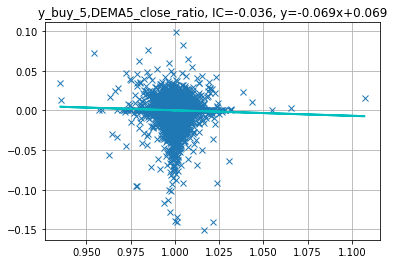

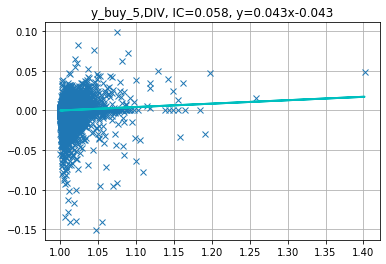

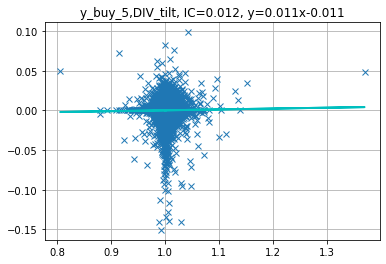

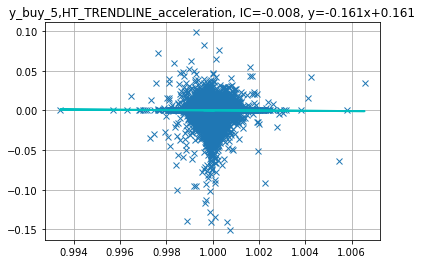

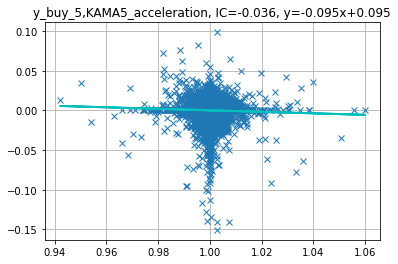

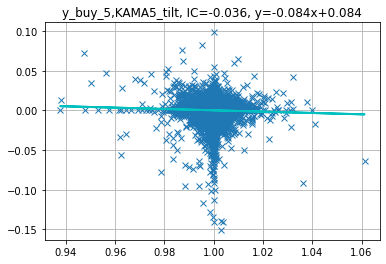

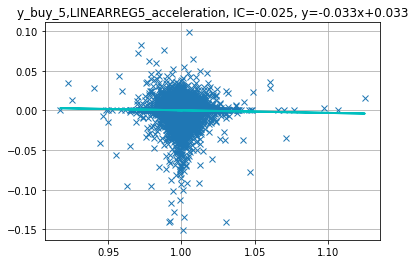

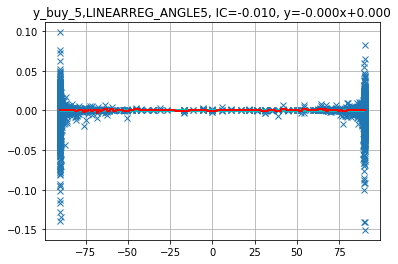

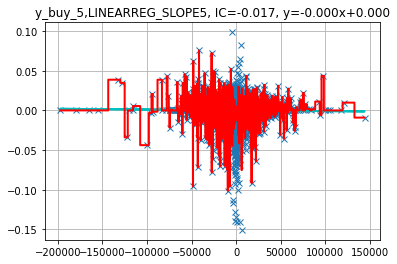

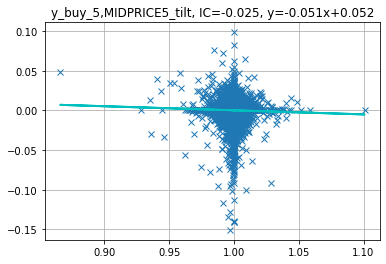

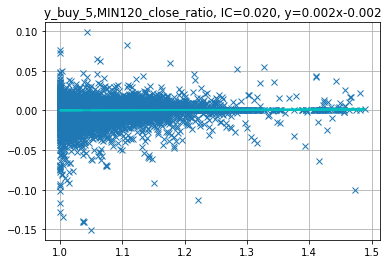

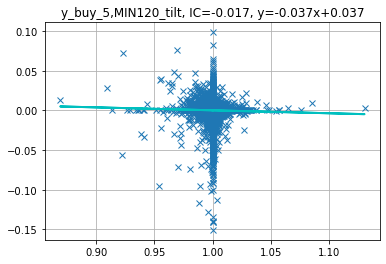

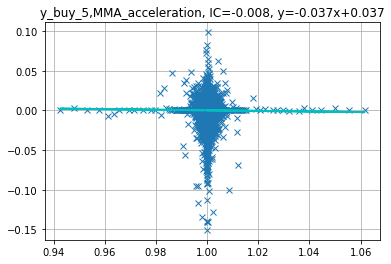

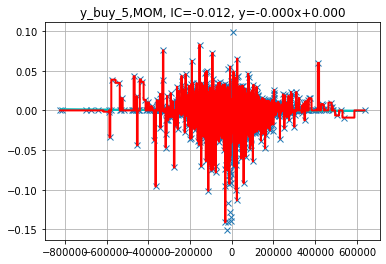

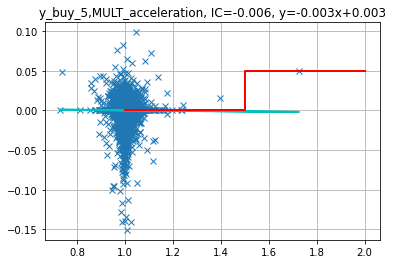

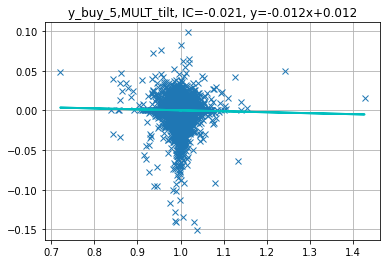

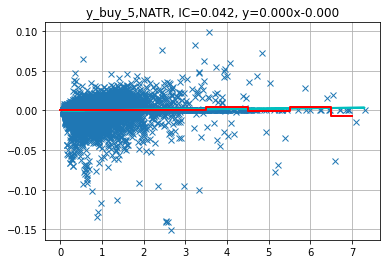

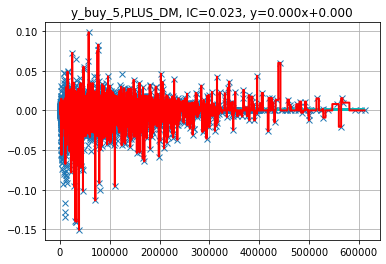

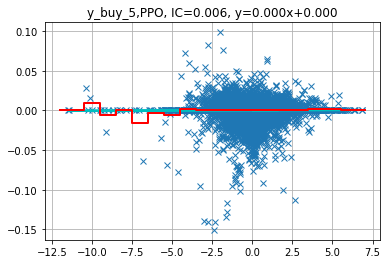

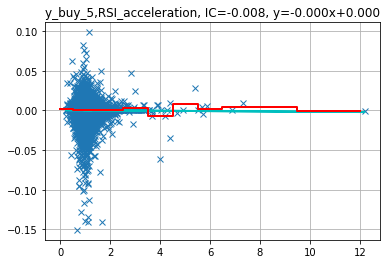

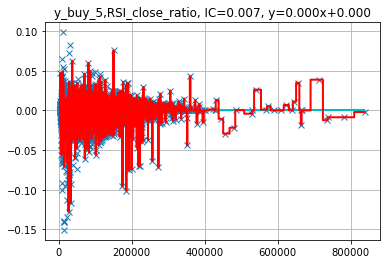

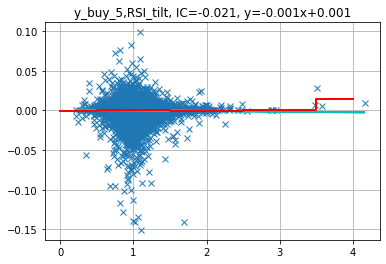

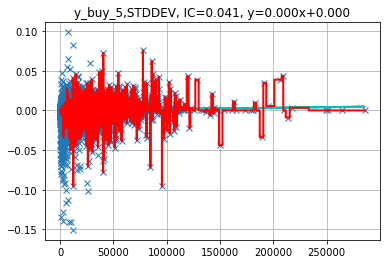

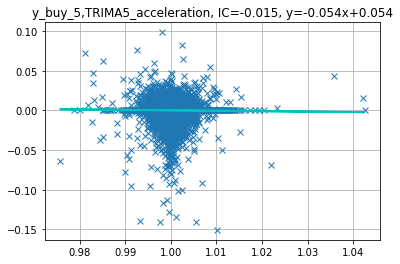

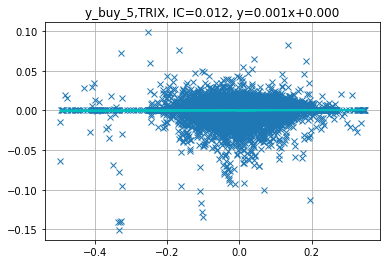

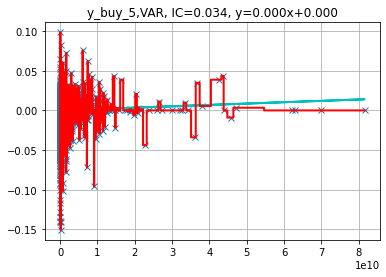

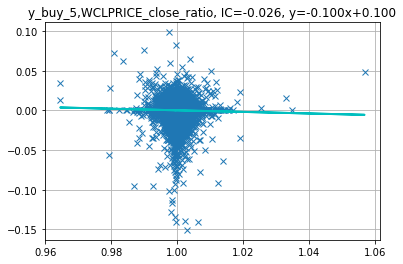

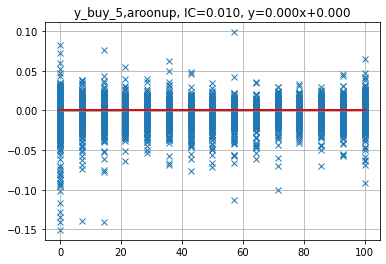

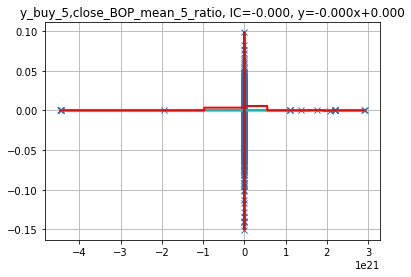

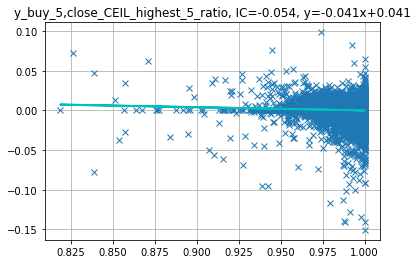

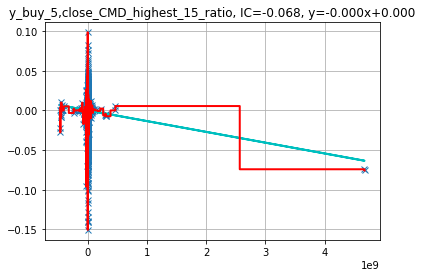

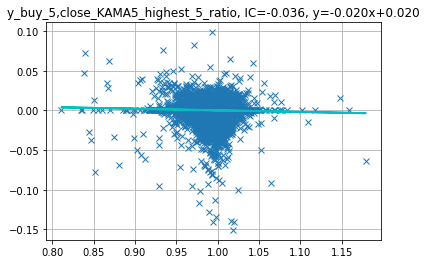

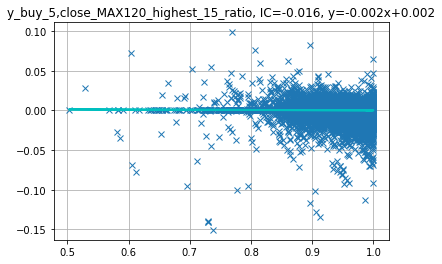

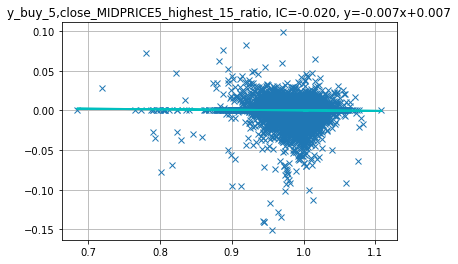

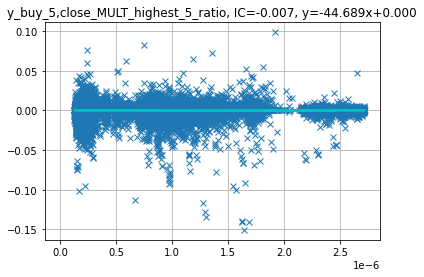

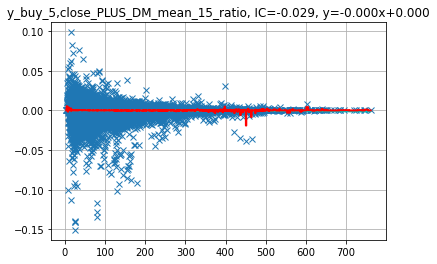

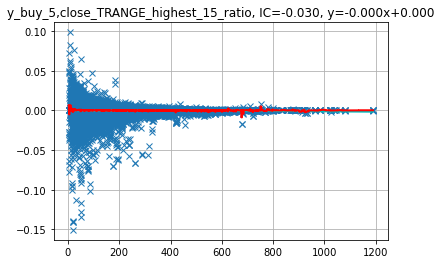

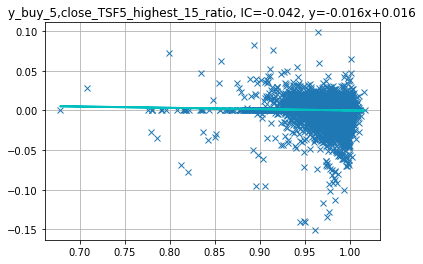

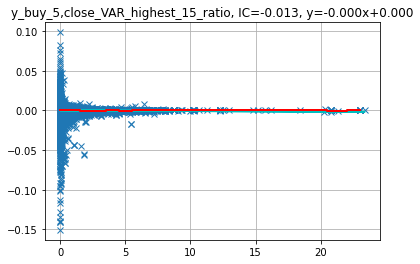

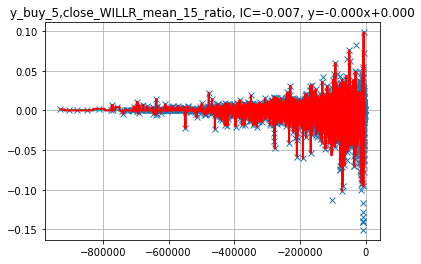

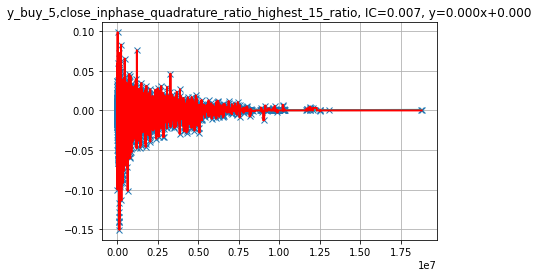

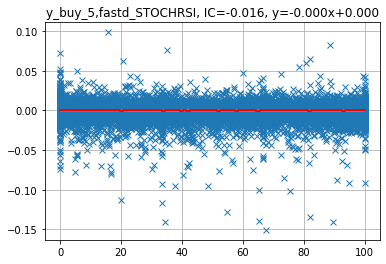

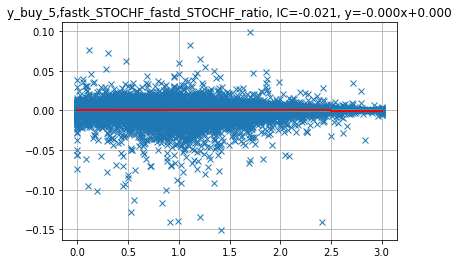

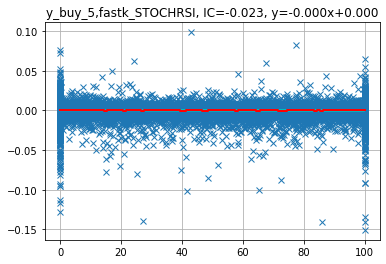

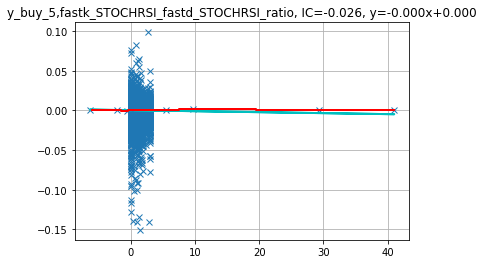

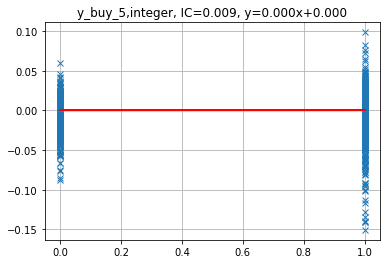

embargo: 162


In [25]:

df_results = feature_calcuration(df, features, IC_scores_df, target_dict)
before_len = len(df_results)

display(df_results)
df = pd.concat([df, df_results], axis=1)

# for i in features:
#     target_feature = target_dict['target_feature']
#     df_ic = target_calucuration(df.copy(), target_dict)
#     df_ic = df_ic.loc[:, [i,target_feature]]
#     df_ic=df_ic.replace([np.inf, -np.inf], np.nan)

#     if df_ic[i].isna().sum() > 500:
#         print(f"{i} too many Nan values")
#         continue
#     df_ic = df_ic.dropna()
#     ic = plot_scatter(target_feature, i, df_ic[i].values, df_ic[target_feature].values)

df = df.round(12)
df.dropna(inplace=True)

after_len = len(df)
embargo =  before_len - after_len
print(f'embargo: {embargo}')


In [26]:
def backtest(
    close: np.ndarray,
    predict_buy_entry: np.ndarray,
    predict_sell_entry: np.ndarray,
    priority_buy_entry: np.ndarray,
    buy_executed: np.ndarray,
    sell_executed: np.ndarray,
    buy_price: np.ndarray,
    sell_price: np.ndarray,
):
    n = close.size
    y = close.copy() * 0.0
    poss = close.copy() * 0.0
    ret = 0.0
    pos = 0.0
    buy_entry_price = 1.0
    sell_entry_price = 1.0
    buy_entry_prices = np.full((n), np.nan)
    sell_entry_prices = np.full((n), np.nan)
    buy_exit_prices = np.full((n), np.nan)
    sell_exit_prices = np.full((n), np.nan)
    for i in range(n):
        prev_pos = pos

        # exit
        # Exit of short
        if buy_executed[i]:
            vol = np.maximum(0, -prev_pos)
            if vol == 1:
                buy_exit_price = buy_price[i]
                buy_exit_prices[i] = buy_price[i]
                ret -= (buy_exit_price / sell_entry_price - 1) * vol
                pos += vol

        # Exit of long
        if sell_executed[i]:
            vol = np.maximum(0, prev_pos)
            if vol == 1:
                sell_exit_price = sell_price[i]
                sell_exit_prices[i] = sell_price[i]
                ret += (sell_exit_price / buy_entry_price - 1) * vol
                pos -= vol

        # entry
        if priority_buy_entry[i] and predict_buy_entry[i] and buy_executed[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * predict_buy_entry[i]
            # ret -= buy_cost[i] * vol
            pos += vol
            if vol == 1:
                buy_entry_price = buy_price[i]
                buy_entry_prices[i] = buy_price[i]

        if not priority_buy_entry[i] and predict_sell_entry[i] and sell_executed[i]:
            vol = np.minimum(1.0, prev_pos + 1) * predict_sell_entry[i]
            pos -= vol
            if vol == 1:
                sell_entry_price = sell_price[i]
                sell_entry_prices[i] = sell_price[i]

        y[i] = ret
        poss[i] = pos

    return y, poss, buy_entry_prices, sell_entry_prices, buy_exit_prices, sell_exit_prices


def richman_backtest(df):

    cumulative_return, possition, buy_entry_prices, sell_entry_prices, buy_exit_prices, sell_exit_prices = backtest(
            close=df["close"].to_numpy(),
            predict_buy_entry=df["predict_buy_entry"].to_numpy() ,
            predict_sell_entry=df["predict_sell_entry"].to_numpy() ,
            priority_buy_entry=df["priority_buy_entry"].to_numpy(),
            buy_executed=df['buy_executed'].to_numpy(),
            sell_executed=df['sell_executed'].to_numpy(),
            buy_price=df['buy_price'].to_numpy(),
            sell_price=df['sell_price'].to_numpy(),
        )
    return pd.DataFrame(
        {
            "cumulative_return": cumulative_return,
            "position": possition,
            "buy_entry_price": buy_entry_prices,
            "sell_entry_price": sell_entry_prices,
            "buy_exit_price": buy_exit_prices,
            "sell_exit_price": sell_exit_prices,
        },
        index=df.index
    )



[100]	valid_0's rmse: 0.00399073
[200]	valid_0's rmse: 0.00400303
[300]	valid_0's rmse: 0.00401418
[400]	valid_0's rmse: 0.00402632
[500]	valid_0's rmse: 0.00403821
[600]	valid_0's rmse: 0.00403983
[700]	valid_0's rmse: 0.00404911
[800]	valid_0's rmse: 0.00405141
[900]	valid_0's rmse: 0.004062
[1000]	valid_0's rmse: 0.00406291


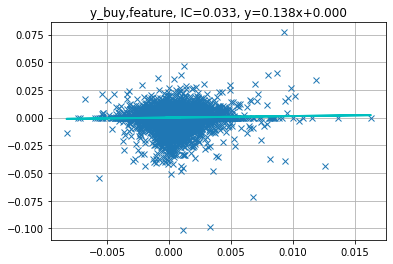

/var/folders/y5/nsb262dx78152c74lm_hjqjc0000gn/T/ipykernel_44915/722103715.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_df['y_pred_buy'] = preds


[100]	valid_0's rmse: 0.00417666
[200]	valid_0's rmse: 0.00420027
[300]	valid_0's rmse: 0.00421261
[400]	valid_0's rmse: 0.00422811
[500]	valid_0's rmse: 0.00424895
[600]	valid_0's rmse: 0.00424692
[700]	valid_0's rmse: 0.00425848
[800]	valid_0's rmse: 0.00426295
[900]	valid_0's rmse: 0.00427869
[1000]	valid_0's rmse: 0.00428085


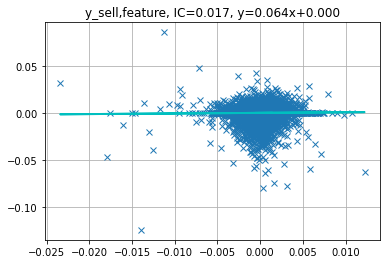

/var/folders/y5/nsb262dx78152c74lm_hjqjc0000gn/T/ipykernel_44915/722103715.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_df['y_pred_sell'] = valid_sell_preds
/var/folders/y5/nsb262dx78152c74lm_hjqjc0000gn/T/ipykernel_44915/722103715.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_df["predict_buy_entry"] = backtest_df['y_pred_buy'] > 0
/var/folders/y5/nsb262dx78152c74lm_hjqjc0000gn/T/ipykernel_44915/722103715.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy 

+-------------------------------+---------------------+
|         evaluate index        |        value        |
+-------------------------------+---------------------+
|             start             | 2021-04-24 05:30:00 |
|              end              | 2022-04-18 19:45:00 |
|      Total return percent     |        185.78       |
|           num trades          |         6502        |
|        win rate percent       |        62.87        |
|       lose rate percent       |        37.13        |
|      average gain percent     |        0.0037       |
|      average loss percent     |       -0.0055       |
|           total days          |        359.0        |
|  1day average return percent  |         0.52        |
|  probavility to win in 1 day  |        57.78        |
|    1day average num trades    |        18.06        |
| probavility to win in 1 month |        69.23        |
| 1month average return percent |         6502        |
|     max draw down percent     |        42.03  

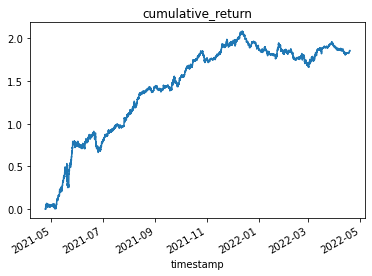

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


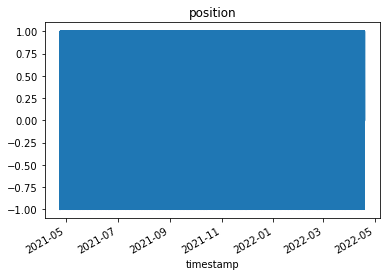

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


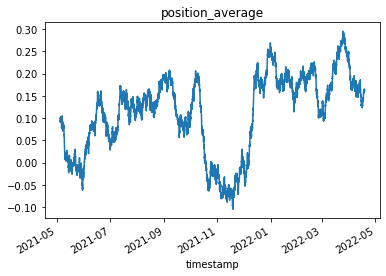

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


,open,high,low,close,volume,fee,ATR,buy_price,sell_price,buy_fep,...,CEIL_acceleration,close_CEIL_highest_5_ratio,MULT_tilt,MULT_acceleration,close_MULT_highest_5_ratio,DIV,DIV_tilt,close_MAX120_highest_15_ratio,MIN120_close_ratio,MIN120_tilt
timestamp,,,,,,,,,,,,,,,,,,,,,
2019/01/02 10:45:00,415117.0,416452.0,414076.0,415232.0,14.92,0.0,1195.017570,414634.0,415830.0,415203.0,...,1.000694,1.000000,1.001319,0.997612,2.407941e-06,1.005738,1.003042,0.988883,1.033599,1.0
2019/01/02 11:00:00,415232.0,416500.0,415232.0,415800.0,8.50,0.0,1200.230600,415200.0,416400.0,415203.0,...,1.000384,1.000000,1.002907,1.001586,2.404245e-06,1.003054,0.997331,0.990236,1.035013,1.0
2019/01/02 11:15:00,416500.0,417366.0,415887.0,415887.0,8.20,0.0,1226.356986,415274.0,416500.0,415203.0,...,0.998843,1.000000,1.003660,1.000750,2.395979e-06,1.003556,1.000501,0.990443,1.035230,1.0
2019/01/02 11:30:00,415887.0,415887.0,415570.0,415800.0,2.31,0.0,1161.402916,415219.0,416381.0,415203.0,...,0.999582,0.999791,0.995697,0.992066,2.395477e-06,1.000763,0.997216,0.990236,1.035013,1.0
2019/01/02 11:45:00,416400.0,416400.0,415570.0,415570.0,1.11,0.0,1137.731279,415001.0,416139.0,415203.0,...,0.999656,0.999238,1.001234,1.005561,2.394152e-06,1.001997,1.001234,0.989688,1.034441,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022/04/18 18:45:00,5164810.0,5172694.0,5152290.0,5161013.0,65.71,0.0,32406.856279,5144810.0,5177216.0,5144810.0,...,1.001027,0.997079,0.995144,0.993542,1.927100e-07,1.003960,0.999187,0.997079,1.050503,1.0
2022/04/18 19:00:00,5163828.0,5172991.0,5137365.0,5144432.0,33.87,0.0,32636.795116,5128114.0,5160750.0,5138955.0,...,0.997734,0.993876,0.997160,1.002027,1.920910e-07,1.006935,1.002963,0.993876,1.047128,1.0
2022/04/18 19:15:00,5144450.0,5170000.0,5141979.0,5155109.0,30.94,0.0,32307.095465,5138955.0,5171263.0,5138955.0,...,1.005305,0.995938,1.000319,1.003168,1.924890e-07,1.005449,0.998525,0.995938,1.049301,1.0


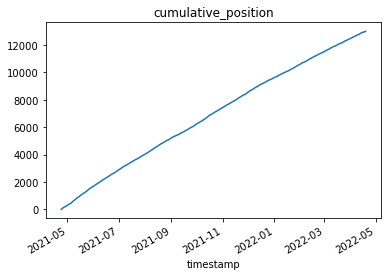

In [27]:
def train_and_save(df,target_col,features,train_parameters):
    X = df[features]
    y = df[target_col]

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=False)
    X_train = X_train[:-embargo]
    y_train = y_train[:-embargo]

    train_data = lgb.Dataset(X_train, y_train)
    valid_data = lgb.Dataset(X_valid, y_valid, reference=train_data)

    trained_model = lgb.train(
        train_parameters,
        train_data,
        num_boost_round=1000,
        valid_sets=[valid_data],
        # early_stopping_rounds = 100, 
        verbose_eval = 100,)

    # 学習曲線の表示
    # lgb.plot_metric(trained_model)

    # model_save and load
    trained_model.save_model(f'model/lgb_model_{target_col}.txt')
    trained_model = lgb.Booster(model_file=f'model/lgb_model_{target_col}.txt')

    preds = trained_model.predict(X_valid)
    ic = np.corrcoef(preds, y_valid)[0, 1]
    plot_scatter(target_col, 'feature', preds, y_valid, normalize=False)

    # backtest
    if target_col == 'y_buy':
      backtest_df = df[X_valid.index[0]: X_valid.index[-1]]
      backtest_df['y_pred_buy'] = preds
      return trained_model, backtest_df

    if target_col == 'y_sell':
      return trained_model, preds

# train_parameters = {
# 'boosting_type': 'rf',  # default = 'gbdt'
# 'metric': 'rmse',
# 'num_leaves': 31,         # default = 31,
# 'learning_rate': 1,    # default = 0.1
# 'feature_fraction': 0.8,  # default = 1.0
# 'bagging_freq': 1,        # default = 0
# 'bagging_fraction': 0.8,  # default = 1.0
# 'random_state': 0,        # default = None
# 'max_depth': 9
# }

train_parameters = {
'objective': 'regression',
'metric': 'rmse',
'verbosity': -1,
'boosting_type': 'dart',
'lambda_l1': 0.1463894505800834,
'lambda_l2': 3.8628956682033713,
'num_leaves': 240,
'feature_fraction': 0.803334859033497,
'bagging_fraction': 0.9502934982338573,
'bagging_freq': 6,
'min_child_samples': 96,
'learning_rate': 0.08362636819642999,
'max_depth': 490}

# train_parameters = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'verbosity': -1,
#     'boosting_type': 'gbdt',
#     'lambda_l1': 1.9996937704054815e-08,
#     'lambda_l2': 9.782575099642981,
#     'num_leaves': 222,
#     'feature_fraction': 0.6569841107555469,
#     'bagging_fraction': 0.9994177275426709,
#     'bagging_freq': 4,
#     'min_child_samples': 6,
#     'learning_rate': 0.06017641042684331,
#     'max_depth': 181,
#     }

buy_model, backtest_df = train_and_save(df,'y_buy',features,train_parameters)
# pickle.dump(buy_model, open("model/lgb_buy_model_rf.pkl", "wb"))
buy_model.save_model('model/lgb_buy_model_rf.txt')

sell_model, valid_sell_preds = train_and_save(df,'y_sell',features,train_parameters)
sell_model.save_model('model/lgb_sell_model_rf.txt')



backtest_df['y_pred_sell'] = valid_sell_preds

# validation backtest

# 予測値の計算
backtest_df["predict_buy_entry"] = backtest_df['y_pred_buy'] > 0
backtest_df["predict_sell_entry"] = backtest_df['y_pred_sell'] > 0
# df["predict_sell_entry"] = False

backtest_df["priority_buy_entry"] = backtest_df['y_pred_buy'] > backtest_df['y_pred_sell']

df_result = richman_backtest(backtest_df)
result_dict = evaluation_index(df_result)

df_result['cumulative_return'].plot()
plt.title('cumulative_return')
plt.show()

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
df_result['position'].plot()
plt.title('position')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
df_result['position'].rolling(1000).mean().plot()
plt.title('position_average')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
df_result['position'].diff(1).abs().dropna().cumsum().plot()
plt.title('cumulative_position')


display(df)

In [28]:
buy_model = lgb.Booster(model_file=f'model/lgb_model_y_buy.txt')
sell_model = lgb.Booster(model_file=f'model/lgb_model_y_sell.txt')

X_valid = df[features]
display(X_valid)
y_pred_buy = buy_model.predict(X_valid)
y_pred_sell = sell_model.predict(X_valid)

df['y_pred_buy'] = y_pred_buy
df['y_pred_sell'] = y_pred_sell

display(df)

df.to_csv('a.csv')

,ADXR_acceleration,ADXR_tilt,ADX_acceleration,ADX_tilt,ATAN_acceleration,ATAN_tilt,BBANDS_ratio_1,BBANDS_ratio_2_acceleration,BBANDS_ratio_2_tilt,BOP,...,close_TRANGE_highest_15_ratio,close_TSF5_highest_15_ratio,close_VAR_highest_15_ratio,close_WILLR_mean_15_ratio,close_inphase_quadrature_ratio_highest_15_ratio,fastd_STOCHRSI,fastk_STOCHF_fastd_STOCHF_ratio,fastk_STOCHRSI,fastk_STOCHRSI_fastd_STOCHRSI_ratio,integer
timestamp,,,,,,,,,,,,,,,,,,,,,
2019/01/02 10:45:00,0.968492,0.935751,0.996206,0.945618,1.0,1.0,1.002672,1.000619,1.001207,0.048401,...,174.760943,0.998510,0.728515,-5638.559556,1.258830e+04,100.000000,0.900646,100.000000,1.000000,1
2019/01/02 11:00:00,1.009185,0.944346,1.003209,0.948652,1.0,1.0,1.003295,1.000041,1.001247,0.447950,...,175.000000,0.998894,0.729511,-5855.292976,1.260552e+04,100.000000,1.178246,100.000000,1.000000,1
2019/01/02 11:15:00,1.021021,0.964197,1.040197,0.986786,1.0,1.0,1.002340,0.996848,0.998092,-0.414469,...,175.036616,0.999027,0.729664,-6036.942742,1.260816e+04,100.000000,0.939118,100.000000,1.000000,0
2019/01/02 11:30:00,0.987415,0.952063,0.982938,0.969949,1.0,1.0,1.001994,1.001219,0.999309,-0.274448,...,175.000000,0.998818,0.729511,-6235.945074,1.260552e+04,96.513157,0.843222,89.539471,0.927744,0
2019/01/02 11:45:00,1.020517,0.971596,1.024261,0.993480,1.0,1.0,1.001143,0.998989,0.998298,-1.000000,...,174.903199,0.998266,0.729108,-6144.276007,1.259855e+04,75.056350,0.867339,35.629578,0.474704,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022/04/18 18:45:00,0.991217,1.009343,0.979854,1.046827,1.0,1.0,1.010474,0.997837,0.994140,-0.186091,...,45.534064,0.992272,0.002215,-138916.818934,4.621458e+06,67.150544,0.872072,35.226617,0.524592,1
2022/04/18 19:00:00,0.990608,0.999863,0.979077,1.024924,1.0,1.0,1.006556,0.998043,0.992194,-0.544434,...,45.387775,0.989084,0.002207,-146399.227026,4.606611e+06,33.817210,0.668490,0.000000,0.000000,1
2022/04/18 19:15:00,0.987465,0.987330,0.997714,1.022581,1.0,1.0,1.004106,1.002940,0.995111,0.380393,...,45.481975,0.991137,0.002212,-160527.377393,4.616172e+06,16.330284,0.732541,13.764236,0.842866,1


,open,high,low,close,volume,fee,ATR,buy_price,sell_price,buy_fep,...,MULT_tilt,MULT_acceleration,close_MULT_highest_5_ratio,DIV,DIV_tilt,close_MAX120_highest_15_ratio,MIN120_close_ratio,MIN120_tilt,y_pred_buy,y_pred_sell
timestamp,,,,,,,,,,,,,,,,,,,,,
2019/01/02 10:45:00,415117.0,416452.0,414076.0,415232.0,14.92,0.0,1195.017570,414634.0,415830.0,415203.0,...,1.001319,0.997612,2.407941e-06,1.005738,1.003042,0.988883,1.033599,1.0,-0.000828,-0.000411
2019/01/02 11:00:00,415232.0,416500.0,415232.0,415800.0,8.50,0.0,1200.230600,415200.0,416400.0,415203.0,...,1.002907,1.001586,2.404245e-06,1.003054,0.997331,0.990236,1.035013,1.0,-0.000600,0.000250
2019/01/02 11:15:00,416500.0,417366.0,415887.0,415887.0,8.20,0.0,1226.356986,415274.0,416500.0,415203.0,...,1.003660,1.000750,2.395979e-06,1.003556,1.000501,0.990443,1.035230,1.0,-0.000353,0.000125
2019/01/02 11:30:00,415887.0,415887.0,415570.0,415800.0,2.31,0.0,1161.402916,415219.0,416381.0,415203.0,...,0.995697,0.992066,2.395477e-06,1.000763,0.997216,0.990236,1.035013,1.0,-0.000572,0.000510
2019/01/02 11:45:00,416400.0,416400.0,415570.0,415570.0,1.11,0.0,1137.731279,415001.0,416139.0,415203.0,...,1.001234,1.005561,2.394152e-06,1.001997,1.001234,0.989688,1.034441,1.0,-0.000009,-0.000105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022/04/18 18:45:00,5164810.0,5172694.0,5152290.0,5161013.0,65.71,0.0,32406.856279,5144810.0,5177216.0,5144810.0,...,0.995144,0.993542,1.927100e-07,1.003960,0.999187,0.997079,1.050503,1.0,0.000960,0.000427
2022/04/18 19:00:00,5163828.0,5172991.0,5137365.0,5144432.0,33.87,0.0,32636.795116,5128114.0,5160750.0,5138955.0,...,0.997160,1.002027,1.920910e-07,1.006935,1.002963,0.993876,1.047128,1.0,0.001610,0.000471
2022/04/18 19:15:00,5144450.0,5170000.0,5141979.0,5155109.0,30.94,0.0,32307.095465,5138955.0,5171263.0,5138955.0,...,1.000319,1.003168,1.924890e-07,1.005449,0.998525,0.995938,1.049301,1.0,0.000735,0.000703


In [29]:
def plot_result(x, returns,ic):
    # 散布図
    plt.plot(x, returns, 'x')
    # 回帰直線
    reg = np.polyfit(x, returns, 1)
    plt.plot(x, np.poly1d(reg)(x), color='c', linewidth=2)
    # 区間平均値
    plt.plot(*_steps(x, returns), drawstyle='steps-mid', color='r', linewidth=2)

    # 相関係数（情報係数）
    plt.title(f'IC={ic:.4f}, y={reg[0]:.4f}x{reg[1]:+.4f}')
    plt.grid()
    plt.show()
    plt.close()

In [30]:
def cross_validation(df,embargo,features,target_feature,train_parameters):
    y_pred = df[target_feature].values.copy()
    y_pred[:] = np.nan

    kf = KFold(n_splits=5)
    kf.get_n_splits(df)
    r2_scores_list = []
    for train_index, test_index in kf.split(df):

        df_train, df_test = df.iloc[train_index[0]:train_index[-1]-embargo,:], df.iloc[test_index[0]:test_index[-1],:]
        X_train = df_train[features]
        y_train = df_train[target_feature]

        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, shuffle=False)
        X_train = X_train[:-embargo]        
        y_train = y_train[:-embargo]

        train_data = lgb.Dataset(X_train, y_train)
        valid_data = lgb.Dataset(X_valid, y_valid, reference=train_data)

        trained_model = lgb.train(
            train_parameters,
            train_data,
            num_boost_round=1000,
            valid_sets=[valid_data],
            # early_stopping_rounds = 100, 
            verbose_eval = 50)

        y_pred[test_index[0]:test_index[-1]] = trained_model.predict(df_test[features])

    return y_pred



df['y_pred_buy'] = cross_validation(df.copy(), embargo, features, 'y_buy', train_parameters)
df['y_pred_sell'] = cross_validation(df.copy(), embargo, features, 'y_sell', train_parameters)

df = df.dropna()
print('result of buy pred')
ic = np.corrcoef(df['y_pred_buy'], df['y_buy'])[0, 1]
plot_result(df['y_pred_buy'],df['y_buy'],ic)

print('result of sell pred')
ic = np.corrcoef(df['y_pred_sell'], df['y_sell'])[0, 1]
plot_result(df['y_pred_sell'],df['y_sell'],ic)

[50]	valid_0's rmse: 0.0034557
[100]	valid_0's rmse: 0.00345763
[150]	valid_0's rmse: 0.0034589
[200]	valid_0's rmse: 0.00346876
[250]	valid_0's rmse: 0.00347442
[300]	valid_0's rmse: 0.00347974
[350]	valid_0's rmse: 0.00348096
[400]	valid_0's rmse: 0.00348664
[450]	valid_0's rmse: 0.00349144
[500]	valid_0's rmse: 0.00349595
[550]	valid_0's rmse: 0.0034974
[600]	valid_0's rmse: 0.00349467
[650]	valid_0's rmse: 0.00349614
[700]	valid_0's rmse: 0.00349857
[750]	valid_0's rmse: 0.00349941
[800]	valid_0's rmse: 0.00350282
[850]	valid_0's rmse: 0.00350517
[900]	valid_0's rmse: 0.0035082
[950]	valid_0's rmse: 0.00350927
[1000]	valid_0's rmse: 0.00351186
[50]	valid_0's rmse: 0.00400095
[100]	valid_0's rmse: 0.00400737
[150]	valid_0's rmse: 0.0040107
[200]	valid_0's rmse: 0.00401894
[250]	valid_0's rmse: 0.00402514
[300]	valid_0's rmse: 0.00403309
[350]	valid_0's rmse: 0.00403688
[400]	valid_0's rmse: 0.00404424
[450]	valid_0's rmse: 0.00405063
[500]	valid_0's rmse: 0.00405628
[550]	valid_0's 

KeyboardInterrupt: 

毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


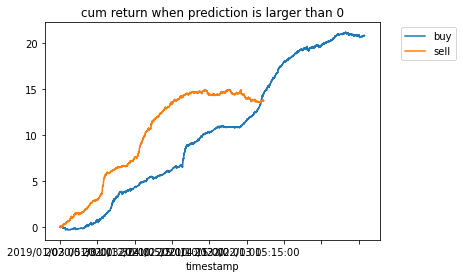

,open,high,low,close,volume,fee,ATR,buy_price,sell_price,buy_fep,...,MULT_tilt,MULT_acceleration,close_MULT_highest_5_ratio,DIV,DIV_tilt,close_MAX120_highest_15_ratio,MIN120_close_ratio,MIN120_tilt,y_pred_buy,y_pred_sell
timestamp,,,,,,,,,,,,,,,,,,,,,
2019/01/02 10:45:00,415117.0,416452.0,414076.0,415232.0,14.92,0.0,1195.017570,414634.0,415830.0,415203.0,...,1.001319,0.997612,2.407941e-06,1.005738,1.003042,0.988883,1.033599,1.0,0.000080,-0.000407
2019/01/02 11:00:00,415232.0,416500.0,415232.0,415800.0,8.50,0.0,1200.230600,415200.0,416400.0,415203.0,...,1.002907,1.001586,2.404245e-06,1.003054,0.997331,0.990236,1.035013,1.0,0.000027,-0.000327
2019/01/02 11:15:00,416500.0,417366.0,415887.0,415887.0,8.20,0.0,1226.356986,415274.0,416500.0,415203.0,...,1.003660,1.000750,2.395979e-06,1.003556,1.000501,0.990443,1.035230,1.0,-0.000055,-0.000417
2019/01/02 11:30:00,415887.0,415887.0,415570.0,415800.0,2.31,0.0,1161.402916,415219.0,416381.0,415203.0,...,0.995697,0.992066,2.395477e-06,1.000763,0.997216,0.990236,1.035013,1.0,0.000079,-0.000463
2019/01/02 11:45:00,416400.0,416400.0,415570.0,415570.0,1.11,0.0,1137.731279,415001.0,416139.0,415203.0,...,1.001234,1.005561,2.394152e-06,1.001997,1.001234,0.989688,1.034441,1.0,0.000094,-0.000422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022/04/18 18:30:00,5177391.0,5187409.0,5162747.0,5165915.0,48.21,0.0,33330.152916,5149250.0,5182580.0,5144810.0,...,1.001612,0.981390,1.928930e-07,1.004777,0.988309,0.998026,1.051501,1.0,-0.000190,0.000139
2022/04/18 18:45:00,5164810.0,5172694.0,5152290.0,5161013.0,65.71,0.0,32406.856279,5144810.0,5177216.0,5144810.0,...,0.995144,0.993542,1.927100e-07,1.003960,0.999187,0.997079,1.050503,1.0,-0.000443,0.000205
2022/04/18 19:00:00,5163828.0,5172991.0,5137365.0,5144432.0,33.87,0.0,32636.795116,5128114.0,5160750.0,5138955.0,...,0.997160,1.002027,1.920910e-07,1.006935,1.002963,0.993876,1.047128,1.0,-0.000341,0.000120


In [ ]:
# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='buy')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='sell')
# (df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('cum return when prediction is larger than 0')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

display(df)

+-------------------------------+---------------------+
|         evaluate index        |        value        |
+-------------------------------+---------------------+
|             start             | 2019-01-02 10:45:00 |
|              end              | 2022-04-18 19:30:00 |
|      Total return percent     |       1279.49       |
|           num trades          |        20626        |
|        win rate percent       |        64.35        |
|       lose rate percent       |        35.65        |
|      average gain percent     |        0.0036       |
|      average loss percent     |       -0.0048       |
|           total days          |        1202.0       |
|  1day average return percent  |         1.06        |
|  probavility to win in 1 day  |        62.65        |
|    1day average num trades    |        17.15        |
| probavility to win in 1 month |         75.0        |
| 1month average return percent |        20626        |
|     max draw down percent     |         95.6  

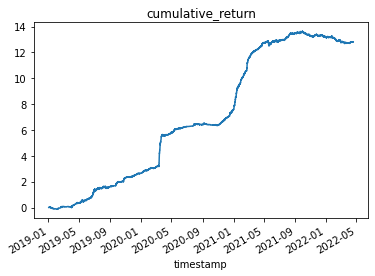

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


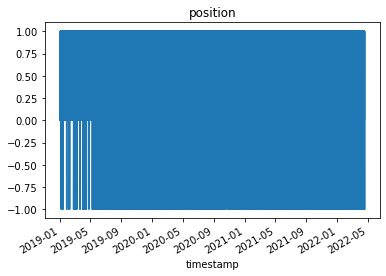

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


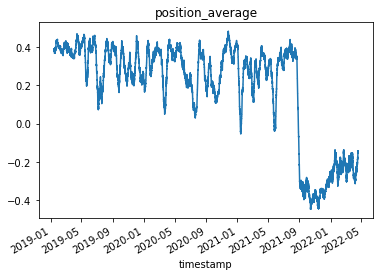

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


,open,high,low,close,volume,fee,ATR,buy_price,sell_price,buy_fep,...,DIV,DIV_tilt,close_MAX120_highest_15_ratio,MIN120_close_ratio,MIN120_tilt,y_pred_buy,y_pred_sell,predict_buy_entry,predict_sell_entry,priority_buy_entry
timestamp,,,,,,,,,,,,,,,,,,,,,
2019/01/02 10:45:00,415117.0,416452.0,414076.0,415232.0,14.92,0.0,1195.017570,414634.0,415830.0,415203.0,...,1.005738,1.003042,0.988883,1.033599,1.0,0.000080,-0.000407,True,False,True
2019/01/02 11:00:00,415232.0,416500.0,415232.0,415800.0,8.50,0.0,1200.230600,415200.0,416400.0,415203.0,...,1.003054,0.997331,0.990236,1.035013,1.0,0.000027,-0.000327,True,False,True
2019/01/02 11:15:00,416500.0,417366.0,415887.0,415887.0,8.20,0.0,1226.356986,415274.0,416500.0,415203.0,...,1.003556,1.000501,0.990443,1.035230,1.0,-0.000055,-0.000417,False,False,True
2019/01/02 11:30:00,415887.0,415887.0,415570.0,415800.0,2.31,0.0,1161.402916,415219.0,416381.0,415203.0,...,1.000763,0.997216,0.990236,1.035013,1.0,0.000079,-0.000463,True,False,True
2019/01/02 11:45:00,416400.0,416400.0,415570.0,415570.0,1.11,0.0,1137.731279,415001.0,416139.0,415203.0,...,1.001997,1.001234,0.989688,1.034441,1.0,0.000094,-0.000422,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022/04/18 18:30:00,5177391.0,5187409.0,5162747.0,5165915.0,48.21,0.0,33330.152916,5149250.0,5182580.0,5144810.0,...,1.004777,0.988309,0.998026,1.051501,1.0,-0.000190,0.000139,False,True,False
2022/04/18 18:45:00,5164810.0,5172694.0,5152290.0,5161013.0,65.71,0.0,32406.856279,5144810.0,5177216.0,5144810.0,...,1.003960,0.999187,0.997079,1.050503,1.0,-0.000443,0.000205,False,True,False
2022/04/18 19:00:00,5163828.0,5172991.0,5137365.0,5144432.0,33.87,0.0,32636.795116,5128114.0,5160750.0,5138955.0,...,1.006935,1.002963,0.993876,1.047128,1.0,-0.000341,0.000120,False,True,False


81560
114516


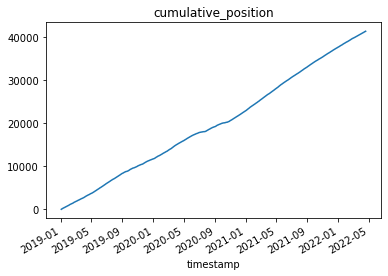

In [ ]:

# 予測値の計算
df["predict_buy_entry"] = df['y_pred_buy'] > 0
df["predict_sell_entry"] = df['y_pred_sell'] > 0
# df["predict_sell_entry"] = False

df["priority_buy_entry"] = df['y_pred_buy'] > df['y_pred_sell']

df_result = richman_backtest(df)
result_dict = evaluation_index(df_result)

df_result['cumulative_return'].plot()
plt.title('cumulative_return')
plt.show()

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
df_result['position'].plot()
plt.title('position')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
df_result['position'].rolling(1000).mean().plot()
plt.title('position_average')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
df_result['position'].diff(1).abs().dropna().cumsum().plot()
plt.title('cumulative_position')

display(df)
print(len(df[df['y_pred_buy'] > 0]))
print(len(df))

# optuna

## target = y_buy

↓区切り線  
*****

In [ ]:
import sklearn.datasets
import sklearn.metrics
from sklearn.metrics import mean_squared_error
import optuna

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=False)
X_train = X_train[:-embargo]
y_train = y_train[:-embargo]


# 1. Define an objective function to be maximized.
def objective(trial):
    train_data = lgb.Dataset(X_train, y_train)
    valid_data = lgb.Dataset(X_valid, y_valid, reference=train_data)


    # 2. Suggest values of the hyperparameters using a trial object.
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'dart',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('feature_fraction', 0.0001, 0.1),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'max_depth' : trial.suggest_int("max_depth", 2, 612),
        # min_samples_split = trial.suggest_int("min_samples_split", 2, 612)
    # max_leaf_nodes = int(trial.suggest_int("max_leaf_nodes", 2, 612))
    # criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

    }

    trained_model = lgb.train(
    param,
    train_data,
    num_boost_round=1000,
    valid_sets=[valid_data],
    # early_stopping_rounds = 100, 
    verbose_eval = 1000,)

    preds = trained_model.predict(X_valid[features].values)
    # pred_labels = np.rint(preds)
    # accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    accuracy = np.sqrt(mean_squared_error(y_valid, preds))
    return accuracy



# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'X' is not defined